# Exploring the DBSCAN algorithm

Density-Based Spatial Clustering of Applications with Noise(DBSCAN) is an unsupervised machine learning model, which is robust to noise in the data.

### **Theoretical Understanding**

- **Assumption**:Clusters are regions of high density, separated by regions of low density.

**Features**

- number of clusters need not be mentioned beforehand.
- 2 parameters: 
    - *epsilon*: Radius of circle created around each data point to check density. (Calculated from K-distance graph)

    - *minPoints*: min number of points to be present in the above circle, inorder to label that point as a **core point**. (This should be *atleast 1 greater than the number of dimensions*, Generally it is twice the dimensions.)
- Scans through the entire dataset only once.
- Distance is usually calculated with Euclidean distance.

**Terms**

- *Core point*: A point that has atleast *minPoints* number of elements in the circle of radius *epsilon* around it.

- *Border Point*: if the number of elements is les than *minPoints*, then it is border point.

- *Noise* : If no other point within *epsilon* radius, it is noise.


**Reachability and Connectivity**

- Reachability - if a data point can be accessed from another data point directly or indirectly

    - Directly Density-Reachable: A point X is directly density-reachable from point Y w.r.t *epsilon*,*minPoints* if,

        - X is in the circle with radius *epsilon* where Y is the core point. This is the same concept as an *open ball* in Real Analysis.
    
    - Density-Reachable : A point X is density-reachable from point Y w.r.t *epsilon*, *minPoints* if there is a chain of points p1, p2, p3, …, pn and p1=X and pn=Y such that pi+1 is directly density-reachable from pi.

- Connectivity - whether two data points belong to the same cluster or not.
    - Density-Connected: A point X is density-connected from point Y if both of them lie in the same circle with radius *epsilon* , and a  core point Z. 

____
**About the dataset**

The dataset contains data about customers at a mall.

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
X=pd.read_csv("Mall_Customers.csv")
X.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
X.drop(columns=["CustomerID"],inplace=True) #customer ID is not important

In [5]:
X.columns

Index(['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')

In [6]:
X.describe(include="all")  #initial descriptive statistics

,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200,200.000000,200.000000,200.000000
unique,2,NaN,NaN,NaN
top,Female,NaN,NaN,NaN
freq,112,NaN,NaN,NaN
mean,NaN,38.850000,60.560000,50.200000
std,NaN,13.969007,26.264721,25.823522
min,NaN,18.000000,15.000000,1.000000
25%,NaN,28.750000,41.500000,34.750000
50%,NaN,36.000000,61.500000,50.000000
75%,NaN,49.000000,78.000000,73.000000


The dataset is slightly unbalanced in terms of Gender.

In [7]:
X.isna().sum() #check for null values

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

No null values

**Basic EDA**

<Axes: >

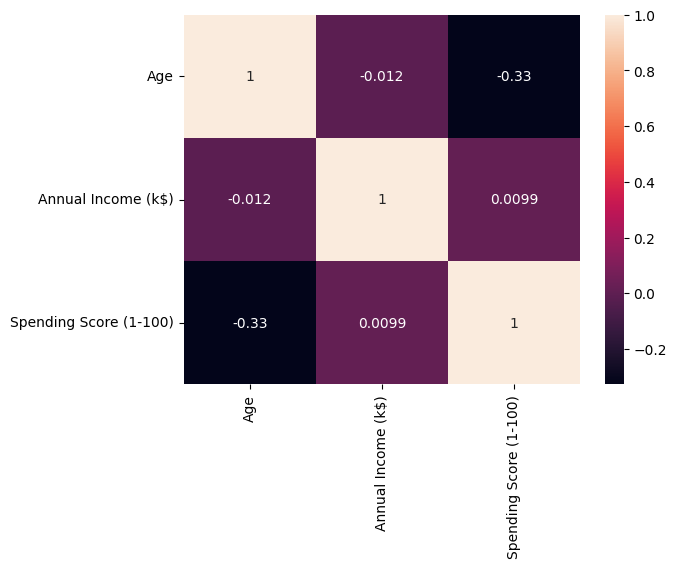

In [8]:
X_corr=X.drop(columns=["Gender"])
sns.heatmap(X_corr.corr(),annot=True) #correlation

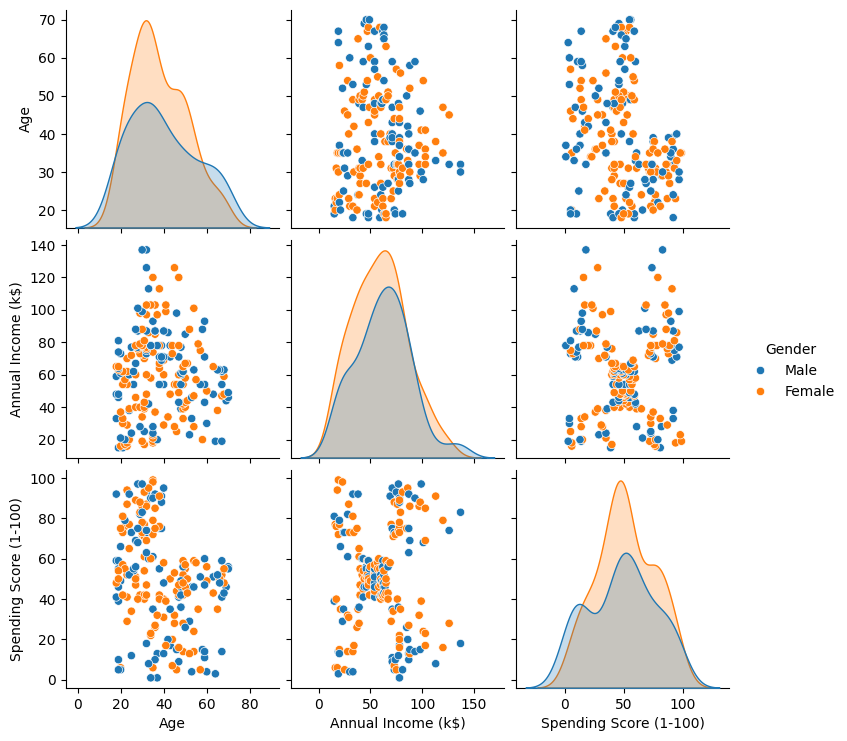

In [9]:
sns.pairplot(X,hue="Gender",diag_kind="kde") #bivariate analysis

<Axes: >

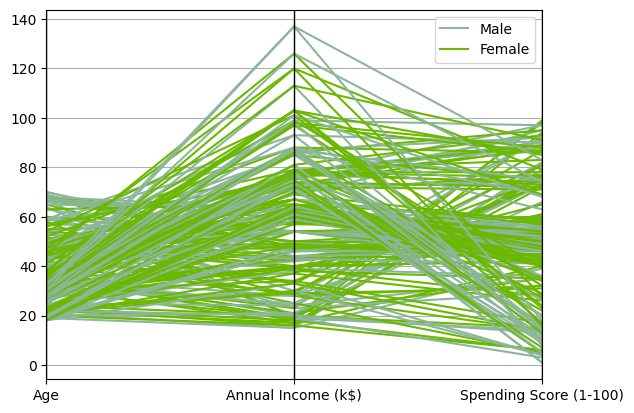

In [10]:
pd.plotting.parallel_coordinates(X, class_column="Gender")

In [11]:
import plotly.express as px

fig = px.parallel_coordinates(X, color="Spending Score (1-100)",
                              color_continuous_scale=px.colors.diverging.delta_r,
                              color_continuous_midpoint=2,width=600,height=400,labels={'Gender':'Gender','Age':'Age', 'Annual Income (k$)':'Annual Income' , 'Spending Score (1-100)':'Spending Score ', })
fig.show()

**Data Preprocessing**

In [12]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

In [30]:
X["Gender"].replace("Male",1,inplace=True)
X["Gender"].replace("Female",2,inplace=True)
X.head()


,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,2,20,16,6
3,2,23,16,77
4,2,31,17,40


In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
trf1 = ColumnTransformer([
    ('col_gender',OneHotEncoder(sparse_output=False,handle_unknown='ignore'),[0])
],remainder='passthrough')
x_trans=trf1.fit_transform(X)
x_trans=pd.DataFrame(x_trans,columns=['Male','Female', 'Age', 'Annual Income', 'Spending Score'])
x_trans.head()

,Male,Female,Age,Annual Income,Spending Score
0,1.0,0.0,19.0,15.0,39.0
1,1.0,0.0,21.0,15.0,81.0
2,0.0,1.0,20.0,16.0,6.0
3,0.0,1.0,23.0,16.0,77.0
4,0.0,1.0,31.0,17.0,40.0


In [15]:
trf2=MinMaxScaler()
x_trans[['Age', 'Annual Income', 'Spending Score']]=trf2.fit_transform(x_trans[['Age', 'Annual Income', 'Spending Score']])


In [16]:
x_trans.head()

,Male,Female,Age,Annual Income,Spending Score
0,1.0,0.0,0.019231,0.000000,0.387755
1,1.0,0.0,0.057692,0.000000,0.816327
2,0.0,1.0,0.038462,0.008197,0.051020
3,0.0,1.0,0.096154,0.008197,0.775510
4,0.0,1.0,0.250000,0.016393,0.397959


**DBSCAN**

Many trials of DBSCAN was done, and in some cases, like when eps=3, all points were clustered into one group.
this is normal, becuase all features were scaled betweeen 0 to 1, and so definitely, all points will be within 1 unit distance of each other.

GridSearchCV for DBSCAN was not working because Silhouette Coefficient could not be passed into it as an evaluation metrics. So I made one that suited my needs.

Many resources have mentioned that Euclidean distance becomes less acurate with increase in dimensionality. On the other hand, among the other distance metrics, Mahalanobis and Manhattan distances were frequently claimed to be good for high dimensional data. A comparison of these metrics is also done.

In [17]:
x_trans.head()

,Male,Female,Age,Annual Income,Spending Score
0,1.0,0.0,0.019231,0.000000,0.387755
1,1.0,0.0,0.057692,0.000000,0.816327
2,0.0,1.0,0.038462,0.008197,0.051020
3,0.0,1.0,0.096154,0.008197,0.775510
4,0.0,1.0,0.250000,0.016393,0.397959


**eps=0.1,0.2 with euclidean distance**

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import DBSCAN
import numpy as np


clustering = DBSCAN()
parameters={'eps':[0.1,0.2],"min_samples":[7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
for eps in parameters["eps"]:
    for samples in parameters["min_samples"]:
        
        clustering = DBSCAN(eps=eps, min_samples=samples).fit(x_trans)
        x_trans.insert(0, 'cluster',clustering.labels_)
        components = clustering.components_
        labels =clustering.labels_
        x_trans['cluster'].astype(str)
        
        unique=x_trans['cluster'].value_counts()
        if len(unique)>1:  #checking for more than one cluster
            sc = metrics.silhouette_score(x_trans.iloc[:,1:], labels)
            if sc>0.5: #checking for silhouete score more than 0.5
                print("eps:",eps,"samples:",samples)
                print("Silhouette Coefficient:%0.2f" % sc)
                print(unique)
        x_trans.drop(columns=["cluster"],inplace=True)


**eps=0.3,0.4 with euclidean distance**

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import DBSCAN
import numpy as np



clustering = DBSCAN()
parameters={'eps':[0.3,0.4],"min_samples":[7,8,9,10,11,12,13,14,15,16,17,18,19,20]}

for eps in parameters["eps"]:
    for samples in parameters["min_samples"]:
        clustering = DBSCAN(eps=eps, min_samples=samples).fit(x_trans)
        x_trans.insert(0, 'cluster',clustering.labels_)
        components = clustering.components_
        labels =clustering.labels_
        x_trans['cluster'].astype(str)
        
        unique=x_trans['cluster'].value_counts()
        if len(unique)>1:
            sc = metrics.silhouette_score(x_trans.iloc[:,1:], labels)
            if sc>0.5:
                print("eps:",eps,"samples:",samples)
                print("Silhouette Coefficient:%0.2f" % sc)
                print(unique)
        x_trans.drop(columns=["cluster"],inplace=True)


eps: 0.4 samples: 7
Silhouette Coefficient:0.63
cluster
1    112
0     88
Name: count, dtype: int64
eps: 0.4 samples: 8
Silhouette Coefficient:0.63
cluster
1    112
0     88
Name: count, dtype: int64
eps: 0.4 samples: 9
Silhouette Coefficient:0.63
cluster
1    112
0     88
Name: count, dtype: int64
eps: 0.4 samples: 10
Silhouette Coefficient:0.63
cluster
1    112
0     88
Name: count, dtype: int64
eps: 0.4 samples: 11
Silhouette Coefficient:0.63
cluster
1    112
0     88
Name: count, dtype: int64
eps: 0.4 samples: 13
Silhouette Coefficient:0.53
cluster
 1    111
 0     87
-1      2
Name: count, dtype: int64
eps: 0.4 samples: 14
Silhouette Coefficient:0.53
cluster
 0    111
 1     87
-1      2
Name: count, dtype: int64
eps: 0.4 samples: 15
Silhouette Coefficient:0.53
cluster
 0    111
 1     87
-1      2
Name: count, dtype: int64
eps: 0.4 samples: 16
Silhouette Coefficient:0.53
cluster
 0    111
 1     87
-1      2
Name: count, dtype: int64
eps: 0.4 samples: 17
Silhouette Coefficient:0.

configs that gave score>0.5 are:
|eps|min_sample|silhouette_score|
----|-------|----|
|0.4|7|0.63|
|0.4|8|0.63|
|0.4|9|0.63|
|0.4|10|0.63|
|0.4|11|0.63|
|0.4|13|0.53|
|0.4|14|0.53|
|0.4|15|0.53|
|0.4|16|0.53|

However in all the cases were silhouette score was 0.63, it just clustered on the basis on gender.

cluster
1    112
0     88
Name: count, dtype: int64
Silhouette Coefficient:0.63


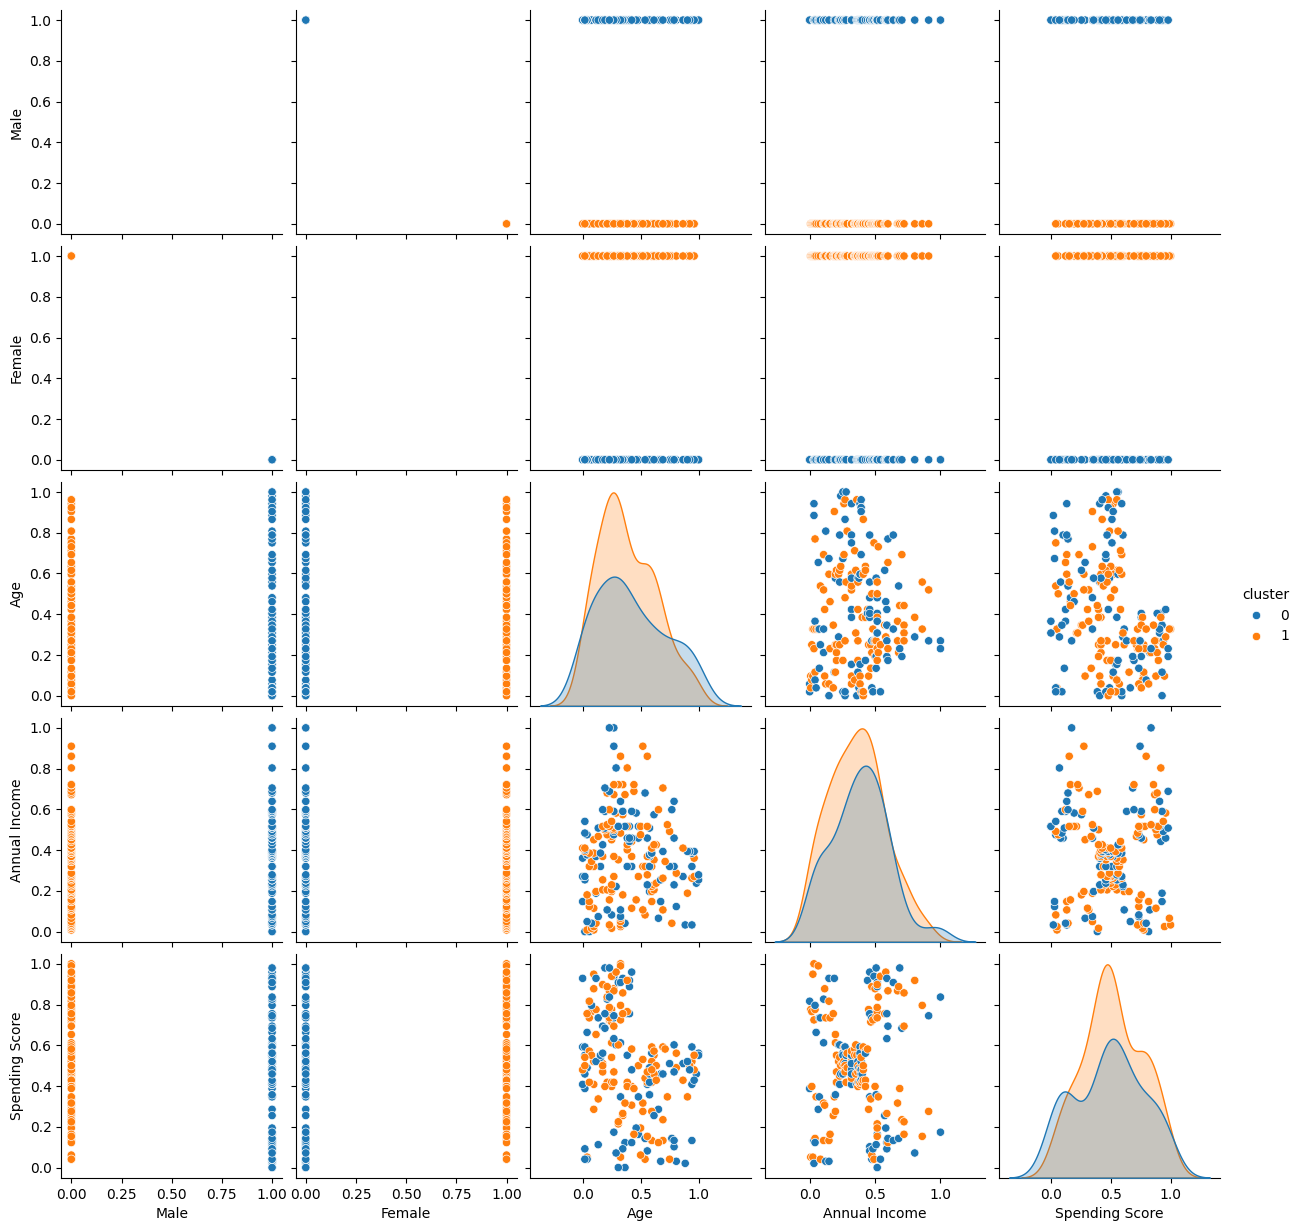

In [20]:
from sklearn.cluster import DBSCAN
import numpy as np


clustering = DBSCAN(eps=0.4, min_samples=7).fit(x_trans)
components = clustering.components_
labels =clustering.labels_
core_sample_indices = clustering.core_sample_indices_
                      

x_trans.insert(0, 'cluster',clustering.labels_)

x_trans.head(10)
x_trans['cluster'].astype(str)
print(x_trans['cluster'].value_counts())
from sklearn import metrics
sc = metrics.silhouette_score(x_trans.iloc[:,1:], labels)
print("Silhouette Coefficient:%0.2f" % sc)
sns.pairplot(x_trans,hue="cluster")
x_trans.drop(columns=["cluster"],inplace=True)

Let's see what the clusters with 0.53 score looked like.

cluster
 0    111
 1     85
-1      4
Name: count, dtype: int64
Silhouette Coefficient:0.50


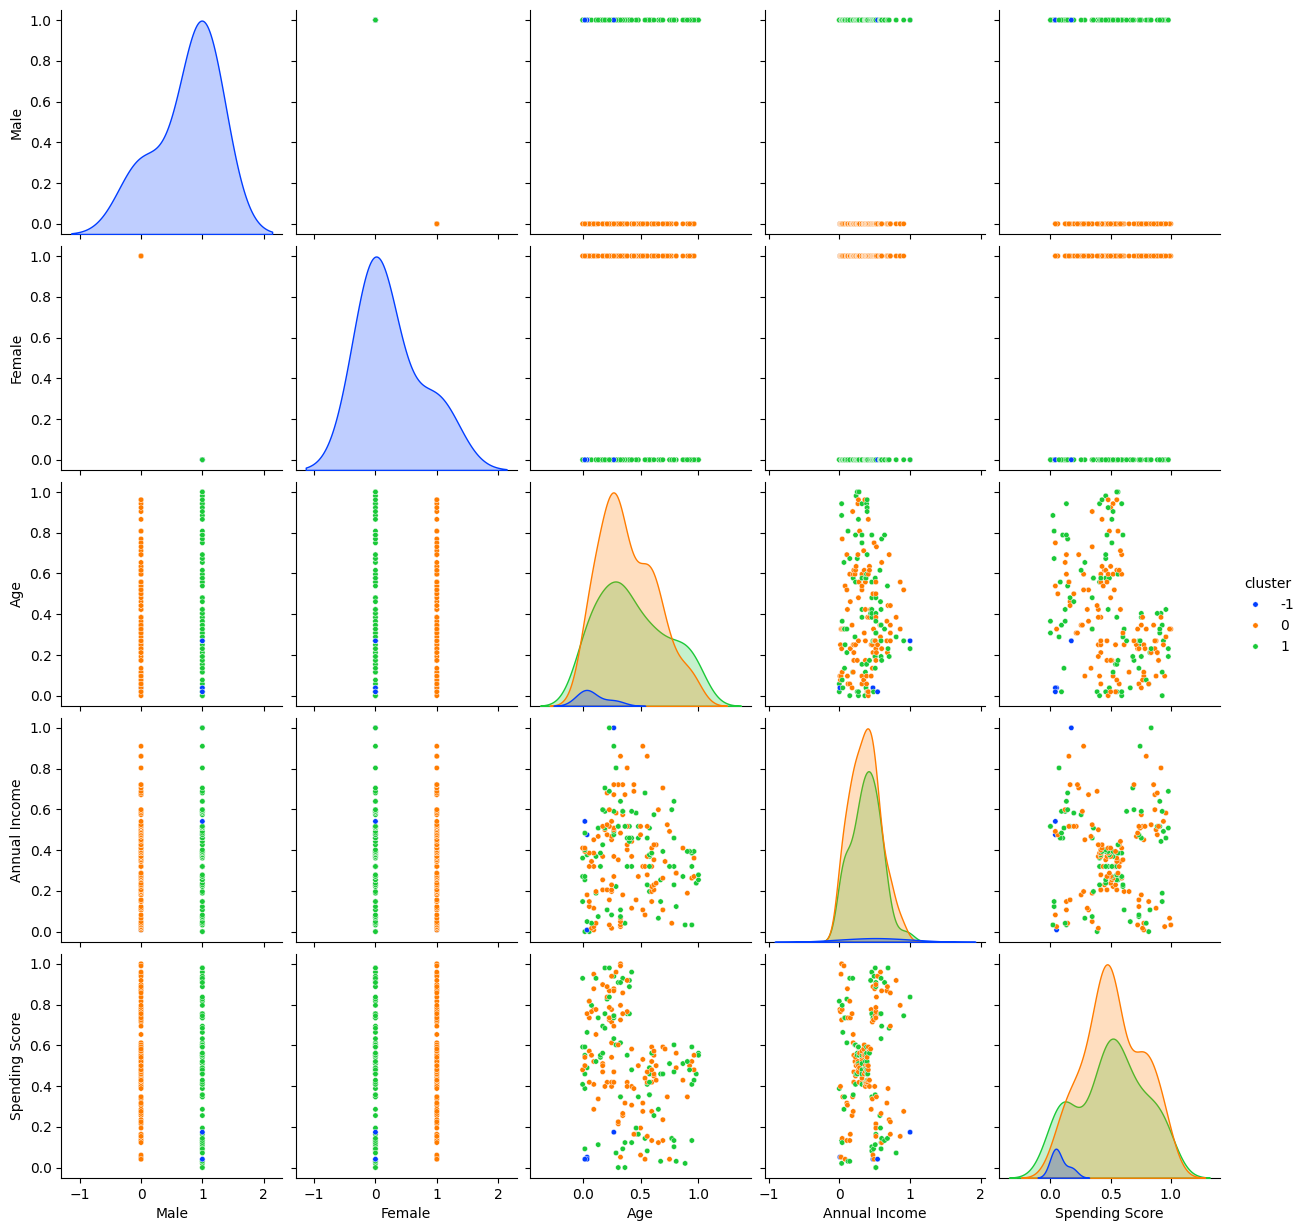

In [22]:
clustering = DBSCAN(eps=0.4, min_samples=18).fit(x_trans)
components = clustering.components_
labels =clustering.labels_
                     

x_trans.insert(0, 'cluster',clustering.labels_)

x_trans.head(10)
x_trans['cluster'].astype(str)
print(x_trans['cluster'].value_counts())
from sklearn import metrics
sc = metrics.silhouette_score(x_trans.iloc[:,1:], labels)
print("Silhouette Coefficient:%0.2f" % sc)
sns.pairplot(x_trans,hue="cluster",diag_kind='kde',palette="bright",plot_kws={"s":15})
x_trans.drop(columns=["cluster"],inplace=True)

This has also more or less clustered in terms of gender, but this time, we have a cluster with label-1 which stands for outliers. In the pairplot, they are  blue in color. It should be noted that the position of a point is an effect of each of the dimensions and a pairplot is a limited representation of this because it shows the position due to 2 variables at a time. 

**Dropping Gender column to see how DBSCAN clusters.**

In [23]:
x_without_gender=x_trans.drop(columns=["Male","Female"])


In [25]:
from sklearn.cluster import DBSCAN
import plotly.express as px 
  
  

plt.close()
clustering = DBSCAN()
parameters={'eps':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],"min_samples":[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
for eps in parameters["eps"]:
    for samples in parameters["min_samples"]:
        clustering = DBSCAN(eps=eps, min_samples=samples).fit(x_without_gender)
        x_without_gender.insert(0, 'cluster',clustering.labels_)
        components = clustering.components_
        labels =clustering.labels_
        x_without_gender['cluster'].astype(str)
        unique=x_without_gender['cluster'].value_counts()

        if len(unique)>1:
            sc = metrics.silhouette_score(x_without_gender.iloc[:,1:], labels)
            print(sc)
            if sc>0:
                print("eps:",eps,"samples:",samples)
                print("Silhouette Coefficient:%0.2f" % sc)
                print(unique)
                
        x_without_gender.drop(columns=["cluster"],inplace=True)

0.15059761879205907
eps: 0.1 samples: 4
Silhouette Coefficient:0.15
cluster
-1    77
 4    32
 2    28
 1    27
 3    20
 0    10
 5     6
Name: count, dtype: int64
0.04535562391226983
eps: 0.1 samples: 5
Silhouette Coefficient:0.05
cluster
-1    98
 6    28
 2    23
 5    19
 3    14
 0     7
 4     6
 1     5
Name: count, dtype: int64
0.02301072386472666
eps: 0.1 samples: 6
Silhouette Coefficient:0.02
cluster
-1    109
 6     25
 1     20
 4     20
 0      7
 2      7
 5      7
 3      5
Name: count, dtype: int64
-0.08026244931739537
-0.13127707066520627
-0.17514655666399914
-0.204847170762306
-0.11986625186929058
-0.15788574833086322
0.2218840942532772
eps: 0.2 samples: 4
Silhouette Coefficient:0.22
cluster
 0    195
-1      5
Name: count, dtype: int64
0.22294991661772784
eps: 0.2 samples: 5
Silhouette Coefficient:0.22
cluster
 0    194
-1      6
Name: count, dtype: int64
0.2179342786052629
eps: 0.2 samples: 6
Silhouette Coefficient:0.22
cluster
 0    190
-1     10
Name: count, dtyp

Only one cluster is formed in most cases, clusters labelled -1 are outliers. This shows how DBSCAN can be used for outlier detection. We plot 3D plots of all cases where we get silhouette score highest.

In [26]:
%matplotlib notebook

In [27]:
eps=0.3
min_sample=20
clustering = DBSCAN(eps=0.3, min_samples=20).fit(x_without_gender)
x_without_gender.insert(0, 'cluster',clustering.labels_)
components = clustering.components_
labels =clustering.labels_
x_without_gender['cluster'].astype(str)
unique=x_without_gender['cluster'].value_counts()

if len(unique)>1:
    sc = metrics.silhouette_score(x_without_gender.iloc[:,1:], labels)
    print(sc)
    if sc>0:
        print("eps:",eps,"samples:",samples)
        print("Silhouette Coefficient:%0.2f" % sc)
        print(unique)
        fig = px.scatter_3d(x_without_gender, x='Age', y='Annual Income', z='Spending Score', color='cluster', 
                    title='3D Scatter Plot ')

        # Update layout to adjust plot size
        fig.update_layout(
            width=800,  # Width of the plot
            height=600  # Height of the plot
        )

        # Show the plot
        fig.show()
x_without_gender.drop(columns=["cluster"],inplace=True)

0.29007392552072675
eps: 0.3 samples: 20
Silhouette Coefficient:0.29
cluster
 0    195
-1      5
Name: count, dtype: int64


This plot clearly shows us the outliers.

*Note: Plotly plots in my system have some kind of bug, they don't convert to HTML. A video which contains the interaction with the plot has been uploaded*

In [29]:
eps=0.1
min_sample=4
clustering = DBSCAN(eps=eps, min_samples=min_sample).fit(x_without_gender)
x_without_gender.insert(0, 'cluster',clustering.labels_)
components = clustering.components_
labels =clustering.labels_
x_without_gender['cluster'].astype(str)
unique=x_without_gender['cluster'].value_counts()

if len(unique)>1:
    sc = metrics.silhouette_score(x_without_gender.iloc[:,1:], labels)
    print(sc)
    if sc>0:
        print("eps:",eps,"samples:",samples)
        print("Silhouette Coefficient:%0.2f" % sc)
        print(unique)
        fig = px.scatter_3d(x_without_gender, x='Age', y='Annual Income', z='Spending Score', color='cluster', 
                    title='3D Scatter Plot ')

        # Update layout to adjust plot size
        fig.update_layout(
            width=800,  # Width of the plot
            height=600  # Height of the plot
        )

        # Show the plot
        fig.show()
x_without_gender.drop(columns=["cluster"],inplace=True)

0.15059761879205907
eps: 0.1 samples: 20
Silhouette Coefficient:0.15
cluster
-1    77
 4    32
 2    28
 1    27
 3    20
 0    10
 5     6
Name: count, dtype: int64


*Note: Plotly plots in my system have some kind of bug, they don't convert to HTML. A video which contains the interaction with the plot has been uploaded*

In this configuration of DBSCAN we get some dense clusters, the non-dense regions are marked as outliers.
These were the observable features:
- Cluster 0: Low annual Income , Young, High Spending Scores
- Cluster 1: Low Annual Income, Young, Average Spending Score
- Cluster 2: Average Annual Income, Middle Aged, Median Spending Score
- Cluster 3: Aged, Median Income, Median Spending Score
- Cluster 4: Young, High Annual Income, High Spending Score
- Cluster 5: Middle Age, Median Annual Income, Low Spending Score

**Conclusion**

DBSCAN is useful in detecting outliers and for identifying dense group of datapoints.

**References**

https://www.kaggle.com/code/bagavathypriya/dbscan-clustering [dataset]

https://medium.com/@dilip.voleti/dbscan-algorithm-for-fraud-detection-outlier-detection-in-a-data-set-60a10ad06ea8

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/